In [275]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import matplotlib.pyplot as plt

In [2]:
a = torch.tensor(1., requires_grad=True)

b = 2 * a

c = a + b

Since $a$ is attached to the computation graph throughout the above, calling `torch.autograd.grad` will give the total derivative

\begin{equation}
    \frac{\mathrm{d} c}{\mathrm{d} a} = 3.
\end{equation}

In [3]:
print(torch.autograd.grad(c, a, retain_graph=True))

(tensor(3.),)


But now let's look at computing the partial derivative

\begin{equation}
\frac{\partial c}{\partial a} = 1.
\end{equation}

In [4]:
a = torch.tensor(1., requires_grad=True)

b = 2 * a.detach()

c = a + b

print(torch.autograd.grad(c, a, retain_graph=True))

(tensor(1.),)


### Univariate normal sampled with reparameterisation trick

Data generating process:

\begin{align}
    \epsilon &\sim \mathcal{N}(0, 1)\\
    \theta &= \mu + \sigma \epsilon
\end{align}

#### Derivatives with respect to $\theta$

In [5]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)
print("Eps", eps)

theta = mu + sigma * eps

Eps tensor([2.2350])


Log probability density for Normal random variable:

In [6]:
sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta - mu , 2) / sigma_sq ) / 2.

Get **partial** derivative with respect to $\theta$, which should be

\begin{equation}
    \frac{\partial \log p(\theta)}{\partial \theta} = - \frac{\epsilon}{\sigma}.
\end{equation}

In [7]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)

theta = mu + sigma * eps

sigma_sq = torch.pow(sigma, 2).detach()
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta - mu.detach() , 2) / sigma_sq ) / 2.

print(torch.autograd.grad(logpth, theta, retain_graph=True)[0])
print(- eps / sigma)

tensor([-0.5933])
tensor([-0.5933], grad_fn=<DivBackward0>)


Get **total** derivative with respect to $\theta$, which should be  $-\epsilon / \sigma$ i.e. the same as partial because $\mu$ and $\sigma$ don't depend on $\theta$?

In [380]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)

theta = mu + sigma * eps

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta - mu , 2) / sigma_sq ) / 2.

print(torch.autograd.grad(logpth, theta, retain_graph=True)[0])
print(- eps / sigma)

tensor([1.1104])
tensor([1.1104], grad_fn=<DivBackward0>)


#### Derivatives with respect to $\sigma$

And **partial** with respect to $\sigma$, which should be

\begin{equation}
    \frac{\partial \log p(\theta)}{\partial \sigma} = - \frac{1}{\sigma} + \frac{\left(\theta - \mu\right)^2}{\sigma^3} = (\epsilon^2 - 1) \frac{1}{\sigma}
\end{equation}

In [378]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)
print("Eps", eps)

theta = mu + sigma * eps

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.

print(torch.autograd.grad(logpth, sigma, retain_graph=True)[0])
print((eps**2 - 1.).detach() / sigma)

Eps tensor([-1.5799])
tensor(1.3601)
tensor([1.3601], grad_fn=<DivBackward0>)


Now **total** derivative with respect to $\sigma$, which should also be

\begin{align}
    \frac{\mathrm{d} \log p(\theta)}{\mathrm{d} \sigma} &= \frac{\partial \log p(\theta)}{\partial \sigma} + \frac{\partial \log p(\theta)}{\partial \mu} \frac{\partial \mu}{\partial \sigma} + \frac{\partial \log p(\theta)}{\partial \theta} \frac{\partial \theta}{\partial \sigma}\\
    &= (\epsilon^2 - 1) \frac{1}{\sigma} + 0 - \frac{\epsilon^2}{\sigma}\\
    &= - \frac{1}{\sigma}
\end{align}

In [10]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)

theta = mu + sigma * eps

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta - mu , 2) / sigma_sq ) / 2.

print(torch.autograd.grad(logpth, sigma, retain_graph=True)[0])
print(- 1. / sigma)

tensor(-0.9091)
tensor(-0.9091, grad_fn=<MulBackward0>)


#### Derivatives with respect to $\mu$

And **partial** with respect to $\mu$, which should be

\begin{equation}
    \frac{\partial \log p(\theta)}{\partial \mu} = \frac{\epsilon}{\sigma}.
\end{equation}

In [11]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)

theta = mu + sigma * eps

# Calling .detach() on this shouldn't make a difference since mu is a leaf node and not a function of sigma
sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.

print(torch.autograd.grad(logpth, mu, retain_graph=True)[0])
print( eps / sigma)

tensor(-0.7944)
tensor([-0.7944], grad_fn=<DivBackward0>)


Now **total** derivative with respect to $\mu$, which should be 0.

In [12]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)

theta = mu + sigma * eps

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta - mu , 2) / sigma_sq ) / 2.
print(torch.autograd.grad(logpth, mu, retain_graph=True)[0])

tensor(0.)


### Looking at what `.backward()` does

In [19]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)

theta = mu + sigma * eps

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta - mu , 2) / sigma_sq ) / 2.
logpth.backward()

print("mu grad", mu.grad)
print("sigma grad", sigma.grad, "; should be", - 1. / sigma)

mu grad tensor(0.)
sigma grad tensor(-0.9091) ; should be tensor(-0.9091, grad_fn=<MulBackward0>)


Detaching `theta` first results in partial derivatives with respect to the leaf variables:

In [22]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)

theta = mu + sigma * eps

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.
logpth.backward()

print("mu grad", mu.grad, "; should be", eps / sigma)
print("sigma grad", sigma.grad, "; should be", (eps**2 - 1.) / sigma)

mu grad tensor(-0.4507) ; should be tensor([-0.4507], grad_fn=<DivBackward0>)
sigma grad tensor(-0.6856) ; should be tensor([-0.6856], grad_fn=<DivBackward0>)


You can get the surrogate loss for the score function estimator like so:

In [248]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)

theta = mu + sigma * eps

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.
loss = torch.pow(theta.detach() - 0.1, 2) + logpth.detach()
(loss * logpth).backward()

print("mu grad", mu.grad, "; should be", loss * eps / sigma)
print("sigma grad", sigma.grad, "; should be", loss * (eps**2 - 1.) / sigma)

mu grad tensor(-0.0044) ; should be tensor([-0.0044], grad_fn=<DivBackward0>)
sigma grad tensor(0.6883) ; should be tensor([0.6883], grad_fn=<DivBackward0>)


But you need to make sure the multiplicative loss term doesn't have a gradient on theta since otherwise it will use chain rule:

In [54]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)

theta = mu + sigma * eps

y = 0.1

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.
loss = torch.pow(theta - y, 2)
(loss * logpth).backward()

print("mu grad", mu.grad, "; should be", (2 * logpth.detach() * (theta.detach() - y) + loss * eps / sigma))
print("sigma grad", sigma.grad, "; should be", (2 * logpth.detach() * (theta.detach() - y) * eps + loss * (eps**2 - 1.) / sigma))

mu grad tensor(-1.6354) ; should be tensor([-1.6354], grad_fn=<AddBackward0>)
sigma grad tensor(-1.2456) ; should be tensor([-1.2456], grad_fn=<AddBackward0>)


What about pathwise loss? LOTUS gives

\begin{equation}
    \nabla_{\phi} \mathbb{E}_{q_{\phi}}\left[ f_{\phi}(\theta) \right] = \mathbb{E}_{\rho(u)} \left[\nabla_{\phi}  \theta(\phi, u) \cdot \nabla_{\theta} f{\phi}(\theta)\right]
\end{equation}

where $\rho(u)$ is the base density used by the flow.

Importantly, you don't want to call backwards multiple times on different terms because this _adds_ the gradients coming from different places:

In [111]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps = torch.randn(1)
print(eps)

theta = mu + sigma * eps

theta.backward(retain_graph=True)

y = 0.1

# sigma_sq = torch.pow(sigma, 2)
# logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.
loss = torch.pow(theta - y, 2)
loss.backward()

print("mu grad", mu.grad, "; should be", 1 + 2 * (theta.detach() - y) )
print("sigma grad", sigma.grad, "; should be", eps + 2 * (theta.detach() - y) * eps )

tensor([0.9450])
mu grad tensor(4.0791) ; should be tensor([4.0791])
sigma grad tensor(3.8550) ; should be tensor([3.8550])


You want to do the following:

In [165]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps0 = torch.randn(1)
eps1 = torch.randn(1)
print("Eps0", eps0)
print("Eps1", eps1)

theta0 = mu + sigma * eps0
theta1 = mu + sigma * eps1
theta = torch.cat((theta0, theta1))
print("theta", theta)

y = 0.1

# sigma_sq = torch.pow(sigma, 2)
# logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.

theta_ = theta.detach().clone()
theta_.requires_grad = True

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta_ - mu , 2) / sigma_sq ).sum() / 2.
loss = torch.pow(theta_.sum() - y, 2) + logpth

gradient_theta = torch.autograd.grad(loss, theta_)

theta_grad = torch.autograd.grad(theta, [mu, sigma], gradient_theta[0])
print("partial loss / partial phi =", theta_grad)

print("Should be:                  ", 4 * (theta.sum().detach() - y) - (eps0 + eps1)/sigma.detach() , ",",
      eps0 * (2 * (theta.sum().detach() - y) - eps0/sigma.detach()) + 
      eps1 * (2 * (theta.sum().detach() - y) - eps1/sigma.detach())
     )

Eps0 tensor([-0.4719])
Eps1 tensor([-1.7025])
theta tensor([ 0.0809, -1.2727], grad_fn=<CatBackward0>)
partial loss / partial phi = (tensor(-3.1906), tensor(2.7806))
Should be:                   tensor([-3.1906]) , tensor([2.7806])


Not the below

In [176]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps0 = torch.randn(1)
eps1 = torch.randn(1)
print("Eps0", eps0)
print("Eps1", eps1)

theta0 = mu + sigma * eps0
theta1 = mu + sigma * eps1
theta = torch.cat((theta0, theta1))
print("theta", theta)

y = 0.1

# sigma_sq = torch.pow(sigma, 2)
# logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.

theta_ = theta.detach().clone()
theta_.requires_grad = True

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ).sum() / 2.
loss = torch.pow(theta_.sum() - y, 2) + logpth

loss.backward()

print("nabla_{\phi} loss =", mu.grad, sigma.grad)

print("Should be:        ", (eps0 + eps1)/sigma.detach() , ",",
      eps0 * (2 * (theta.sum().detach() - y) - eps0/sigma.detach()) + 
      eps1 * (2 * (theta.sum().detach() - y) - eps1/sigma.detach())
     )

Eps0 tensor([-0.7245])
Eps1 tensor([0.2813])
theta tensor([-0.1969,  0.9094], grad_fn=<CatBackward0>)
nabla_{\phi} loss = tensor(-0.4029) tensor(-1.2691)
Should be:         tensor([-0.4029]) , tensor([-1.0919])


In [193]:
sigma = torch.tensor(1.1, requires_grad=True)
mu = torch.tensor(0.6, requires_grad=True)

eps0 = torch.randn(1)
eps1 = torch.randn(1)
print("Eps0", eps0)
print("Eps1", eps1)

theta0 = mu + sigma * eps0
theta1 = mu + sigma * eps1
theta = torch.cat((theta0, theta1))
print("theta", theta)

y = 0.1

# sigma_sq = torch.pow(sigma, 2)
# logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.

sigma_sq = torch.pow(sigma, 2)
logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ).sum() / 2.
loss = torch.pow(theta.sum() - y, 2) + logpth

loss.backward()

print("nabla_{\phi} loss =", mu.grad, sigma.grad)

print("Should be:        ", 4*(theta.sum().detach() - y) + (eps0 + eps1)/sigma.detach() , ",",
      eps0 * (2 * (theta.sum().detach() - y) - eps0/sigma.detach()) + 
      eps1 * (2 * (theta.sum().detach() - y) - eps1/sigma.detach())
     )

Eps0 tensor([0.8238])
Eps1 tensor([-0.4714])
theta tensor([1.5062, 0.0815], grad_fn=<CatBackward0>)
nabla_{\phi} loss = tensor(6.2712) tensor(0.0495)
Should be:         tensor([6.2712]) , tensor([0.2297])


#### Comparing the two Monte Carlo gradient approaches

##### Score:

In [426]:
mu_gradients = []
si_gradients = []

N = 50
y = 0.1

for i in range(100):
    
    sigma = torch.tensor(.4, requires_grad=True)
    mu = torch.tensor(0.6, requires_grad=True)
    mu_gradient, si_gradient = 0., 0.
    
    for n in range(N):
        
        sigma.grad = None
        mu.grad = None
        
        eps0 = torch.randn(1)
        eps1 = torch.randn(1)

        theta0 = mu + sigma * eps0
        theta1 = mu + sigma * eps1
        theta = torch.cat((theta0, theta1))

        sigma_sq = torch.pow(sigma, 2)
        
        logpth = (- torch.log(torch.tensor(2. * torch.pi)) - torch.log(sigma_sq) - 
                  torch.pow( theta.detach() - mu , 2).sum() / (2. * sigma_sq))
        loss = torch.pow(theta.detach().sum() - y, 2) + logpth.detach()
        (loss * logpth).backward()

        mu_gradient = mu_gradient + mu.grad / float(N)
        si_gradient = si_gradient + sigma.grad / float(N)
    
    mu_gradients.append(mu_gradient.detach().item())
    si_gradients.append(si_gradient.detach().item())

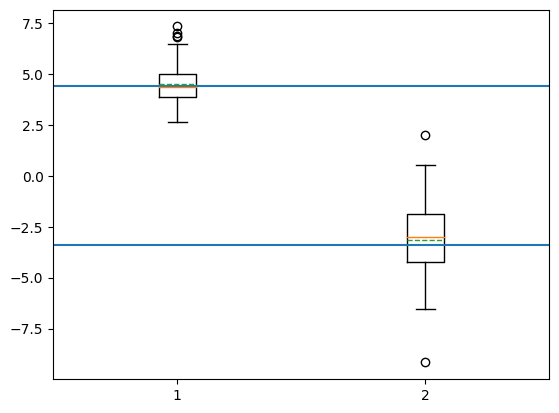

In [427]:
_ = plt.boxplot([mu_gradients, si_gradients], meanline=True, showmeans=True)
plt.axhline(4 * (2 * mu.detach().item() - y), label="mu")
plt.axhline(2 * (2 * sigma.detach().item() - 1./sigma.detach().item()), label="sigma")
ylim = plt.gca().get_ylim()

##### Pathwise:

What about pathwise loss? Law of the unconscious statistician (LOTUS) gives

\begin{equation}
    \nabla_{\phi} \mathbb{E}_{q_{\phi}}\left[ f_{\phi}(\theta) \right] = \mathbb{E}_{\rho(u)} \left[\nabla_{\phi}  \theta(\phi, u) \cdot \nabla_{\theta} f_{\phi}(\theta)\right]
\end{equation}

where $\rho(u)$ is the base density used by flow $q_{\phi}$ and $f_{\phi}(\theta)$ is the loss function.

In [422]:
mu_gradients = []
si_gradients = []

N = 50
y = 0.1

for i in range(100):
    
    mu_gradient, si_gradient = 0., 0.
    sigma = torch.tensor(.4, requires_grad=True)
    mu = torch.tensor(0.6, requires_grad=True)
    
    for n in range(N):
        
        sigma.grad = None
        mu.grad = None
        
        eps0 = torch.randn(1)
        eps1 = torch.randn(1)

        theta0 = mu + sigma * eps0
        theta1 = mu + sigma * eps1
        theta = torch.cat((theta0, theta1))

        sigma_sq = torch.pow(sigma, 2)

        theta_ = theta.detach().clone()
        theta_.requires_grad = True

        logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta_ - mu , 2) / sigma_sq ).sum() / 2.
        loss = torch.pow(theta_.sum() - y, 2) + logpth

        gradient_theta = torch.autograd.grad(loss, theta_)

        theta_grad = torch.autograd.grad(theta, [mu, sigma], gradient_theta[0])
        mu_grad, sigma_grad = theta_grad

        mu_gradient = mu_gradient + mu_grad / float(N)
        si_gradient = si_gradient + sigma_grad / float(N)
    
    mu_gradients.append(mu_gradient.detach().item())
    si_gradients.append(si_gradient.detach().item())

(-11.023450016975403, 8.251079201698303)

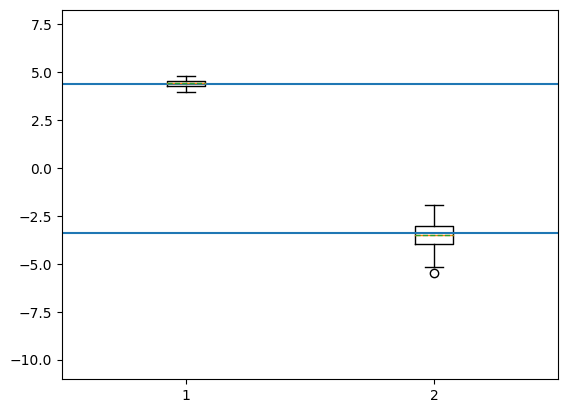

In [423]:
_ = plt.boxplot([mu_gradients, si_gradients], meanline=True, showmeans=True)
plt.axhline(4 * (2 * mu.detach().item() - y), label="mu")
plt.axhline(2 * (2 * sigma.detach().item() - 1./sigma.detach().item()), label="sigma")
plt.ylim(ylim)

##### How not to do pathwise:

This demonstrates that **YOU DO NOT WANT TO JUST CALL BACKWARDS ON THE LOSS** $f_{\phi}$:

In [428]:
mu_gradients = []
si_gradients = []

N = 50
y = 0.1

for i in range(100):
    
    mu_gradient, si_gradient = 0., 0.
    sigma = torch.tensor(.4, requires_grad=True)
    mu = torch.tensor(0.6, requires_grad=True)
    
    for n in range(N):
        
        sigma.grad = None
        mu.grad = None
        
        eps0 = torch.randn(1)
        eps1 = torch.randn(1)

        theta0 = mu + sigma * eps0
        theta1 = mu + sigma * eps1
        theta = torch.cat((theta0, theta1))

        sigma_sq = torch.pow(sigma, 2)

        # sigma_sq = torch.pow(sigma, 2)
        # logpth = - ( torch.log(2. * torch.pi * sigma_sq) + torch.pow( theta.detach() - mu , 2) / sigma_sq ) / 2.

        logpth = - ( 2 * torch.log(torch.tensor(2. * torch.pi)) + torch.log(torch.pow(sigma_sq, 2)) + 
                     torch.pow( theta.detach() - mu , 2).sum() / sigma_sq ) / 2.
        loss = torch.pow(theta.sum() - y, 2) + logpth

        loss.backward()

        mu_gradient = mu_gradient + mu.grad.detach() / float(N)
        si_gradient = si_gradient + sigma.grad.detach() / float(N)
    
    mu_gradients.append(mu_gradient.detach().item())
    si_gradients.append(si_gradient.detach().item())

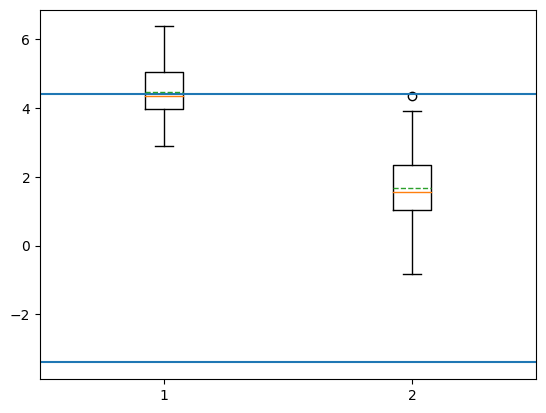

In [429]:
_ = plt.boxplot([mu_gradients, si_gradients], meanline=True, showmeans=True)
plt.axhline(4 * (2 * mu.detach().item() - y), label="mu")
plt.axhline(2 * (2 * sigma.detach().item() - 1./sigma.detach().item()), label="sigma")

## Variational inference for realz with flows

In [271]:
import zuko
import torch.distributions as distributions
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import warnings

In [262]:
from birds.models import StochVolSimulator, StochVolPrior
from birds.plotting import plot_posterior

WARNING, MPI4PY not installed!


In [264]:
device = "cpu"

In [267]:
model = StochVolSimulator(sigma=0.0, T=100)
prior = StochVolPrior()

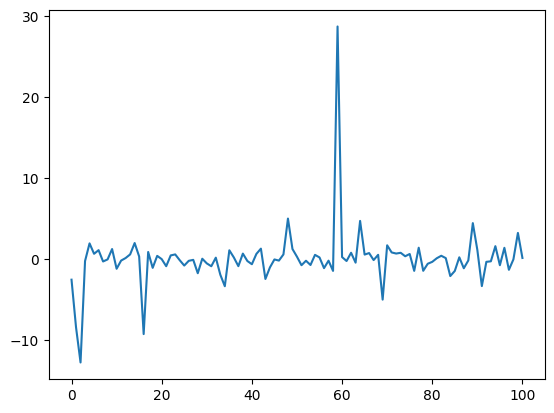

In [266]:
true_parameters = torch.tensor([-1., 3.])

f, ax = plt.subplots()
obs_data = model.forward(true_parameters)
ax.plot(obs_data[0]);

In [440]:
y = obs_data[0]
y_matrix = y.reshape(1,-1,1)
y_sigma = torch.median(torch.pow(torch.cdist(y_matrix, y_matrix), 2))
ny = y.shape[0]
kyy = (torch.exp( - torch.pow(torch.cdist(y_matrix, y_matrix), 2) / y_sigma ) - 
       torch.eye(ny)).sum() / (ny * (ny - 1))

def mmd_loss(y, x):
    
    """
    Assumes x, y are shape (T, C)
    """
    if torch.isnan(x).any():
        warnings.warn("nan sims")
    nx = x.shape[0]
    x_matrix = x.reshape(1,-1,1)
    kxx = torch.exp( - torch.pow(torch.cdist(x_matrix, x_matrix), 2) / y_sigma )
    kxx = (kxx - torch.eye(nx)).sum() / (nx * (nx - 1))
    kxy = torch.exp( - torch.pow(torch.cdist(x_matrix, y_matrix), 2) / y_sigma )
    kxy = kxy.mean()
    kxynan = torch.isnan(kxy)
    if kxynan:
        warnings.warn("kxy nan")
    kxxnan = torch.isnan(kxx)
    if kxxnan:
        warnings.warn("kxx nan")
    return kxx + kyy - 2 * kxy

#### Prior

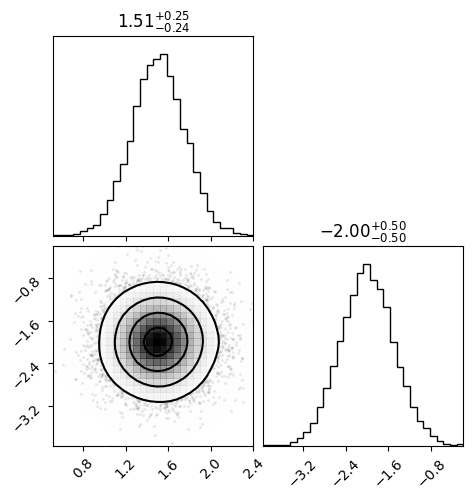

In [441]:
_ = plot_posterior(prior, true_values=torch.tensor([-1., 3.]))

#### Pathwise

Here, we'll train by taking pathwise derivatives. Law of the unconscious statistician (LOTUS) gives

\begin{equation}
    \nabla_{\phi} \mathbb{E}_{q_{\phi}}\left[ f_{\phi}(\theta) \right] = \nabla_{\phi} \mathbb{E}_{\rho(u)}\left[ f_{\phi}(\theta(\phi, u)) \right] = \mathbb{E}_{\rho(u)} \left[\nabla_{\phi}  \theta(\phi, u) \cdot \nabla_{\theta} f_{\phi}(\theta)\right]
\end{equation}

where $\rho(u)$ is the base density used by flow $q_{\phi}$ and

\begin{equation}
    f_{\phi}(\theta) = \ell(\theta, y) + \log q_{\phi}(\theta) - \log \pi(\theta)
\end{equation}

is the loss we're minimising when targetting the generalised posterior

\begin{equation}
    q^*(\theta \mid y) \propto e^{-\ell(\theta, y)} \pi(\theta)
\end{equation}

with our variational procedure.

In the cell below, we'll set the gradients of the flow to be the mean of the results of the Jacobian-vector product seen within the expectation written above.

In [442]:
n_params = 2
flow = zuko.flows.MAF(n_params, 1, transforms=5, hidden_features=[50])
flow = flow.to(device)
print(sum(p.numel() for p in flow.parameters() if p.requires_grad))

2020


In [443]:
import birds.models.stochastic_volatility as stv
new_prior = stv.StochVolPrior()

n_epochs = 1000
best_loss = np.inf
max_num_epochs_no_improve = 25
n_samples = 10

iterator = tqdm(range(n_epochs), position=0, leave=True)
num_epochs_without_improvement = 0

flow_cond = flow(torch.zeros(1))

optim = torch.optim.Adam(flow.parameters(), lr=1e-3) 

w = torch.nn.Parameter(torch.tensor(0.), requires_grad=True)

for it in iterator:
    gradients = None
    total_loss = 0.
    for n in range(n_samples):
        optim.zero_grad()
        theta = flow_cond.rsample((1,))
        theta_ = theta.detach().clone()
        theta_.requires_grad = True
        x = model.forward(theta_)[0]
        forecast_loss = mmd_loss(y, x)
        logqth = flow_cond.log_prob(theta_[0])
        logpth = new_prior.log_prob(theta_)
        loss = forecast_loss #+ w * (logqth - logpth)
        total_loss += loss.detach().item() / float(n_samples)
        gradient_theta = torch.autograd.grad(loss, theta_)
        theta_grad = torch.autograd.grad(theta, [p for p in flow.parameters() if p.requires_grad], 
                                         gradient_theta[0])
        if gradients is None:
            gradients = [p / float(n_samples) for p in theta_grad]
        else:
            for j, grad in enumerate(gradients):
                grad = grad + theta_grad[j] / float(n_samples)
    for j, params in enumerate(flow.parameters()):
        params.grad = gradients[j]
    optim.step()
    if total_loss < best_loss:
        best_loss = total_loss
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1
    if num_epochs_without_improvement > max_num_epochs_no_improve:
        break
    iterator.set_postfix({"loss":total_loss, "best loss":best_loss, "no imp":num_epochs_without_improvement})

 17%|████████████████████▌                                                                                                   | 171/1000 [01:51<08:59,  1.54it/s, loss=-.00136, best loss=-.00415, no imp=25]


tensor(-5.3492)

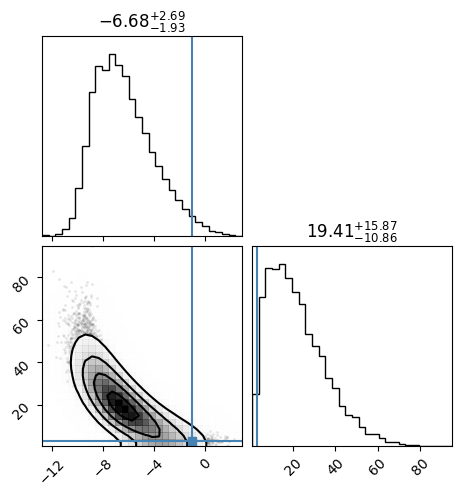

In [444]:
_ = plot_posterior(flow_cond, true_values=torch.tensor([-1., 3.]))#, lims=[[-1.5,1.5], [-0.5, 15]])
flow_cond.log_prob(true_parameters).detach()

tensor(-5.9515)

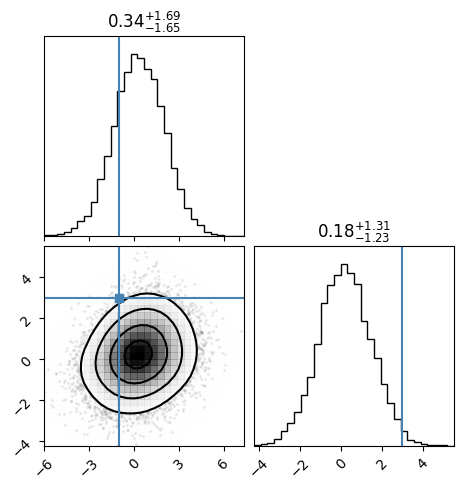

In [445]:
__ = zuko.flows.MAF(n_params, 1, transforms=5, hidden_features=[50])
__ = __.to(device)
__ = __(torch.zeros(1))
_ = plot_posterior(__, true_values=torch.tensor([-1., 3.]))
__.log_prob(true_parameters).detach()

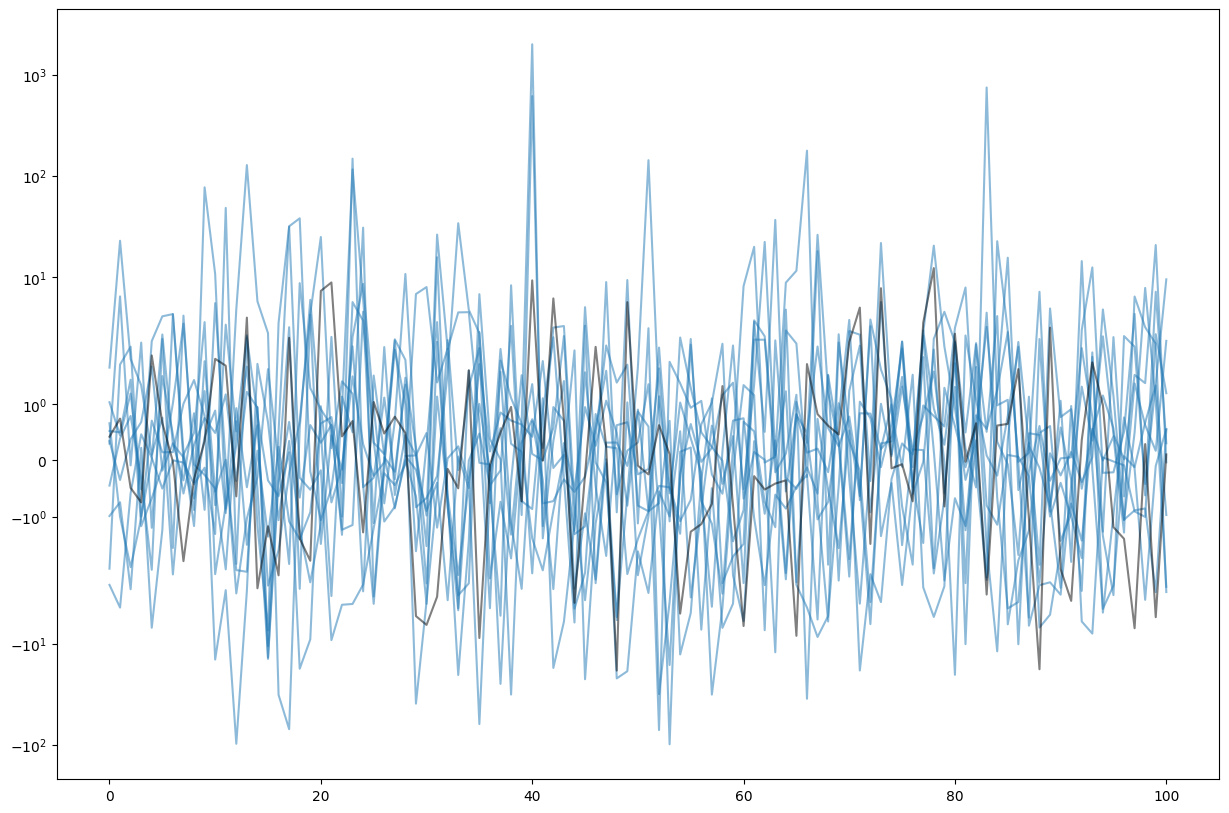

In [446]:
f, ax = plt.subplots(figsize=(15, 10))

for i in range(10):
    sample = flow(torch.ones(1)).sample()
    pred = model(sample)
    ax.plot(pred[0], color = "C0", alpha=0.5)
    
# for i in range(10):
#     sample = prior.rsample(1)
#     pred = model(sample[0])
#     ax.plot(pred[0], color = "C1", alpha=0.5)
    
# for i in range(10):
#     obs_data = model.forward(true_parameters)
#     ax.plot(obs_data[0], color = "black", alpha=0.5);


ax.plot(y, color = "black", alpha=0.5);

ax.set_yscale("symlog")
plt.show()

#### Score

Now we'll train by taking score-based derivatives, which is good for when loss $f_{\phi}(\theta)$ is not differentiable:

\begin{equation}
    \nabla_{\phi} \mathbb{E}_{q_{\phi}}\left[ f_{\phi}(\theta) \right] = \mathbb{E}_{q_{\phi}} \left[ f_{\phi}(\theta)\, \nabla_{\phi} \log q_{\phi}(\theta)\right]
\end{equation}

where 

\begin{equation}
    f_{\phi}(\theta) = \ell(\theta, y) + \log q_{\phi}(\theta) - \log \pi(\theta)
\end{equation}

is the loss we're minimising when targetting the generalised posterior

\begin{equation}
    q^*(\theta \mid y) \propto e^{-\ell(\theta, y)} \pi(\theta)
\end{equation}

with our variational procedure.

This means we can just call `.backwards()` on the surrogate loss

\begin{equation}
    \tilde{f}_{\phi}(\theta) = \log q_{\phi}(\theta) \cdot (\ell(\theta, y) + \log q_{\phi}(\theta) - \log \pi(\theta))\texttt{.detach()}
\end{equation}

In [452]:
n_params = 2
flow = zuko.flows.MAF(n_params, 1, transforms=5, hidden_features=[50])
flow = flow.to(device)
print(sum(p.numel() for p in flow.parameters() if p.requires_grad))

2020


In [453]:
import birds.models.stochastic_volatility as stv
new_prior = stv.StochVolPrior()

n_epochs = 1000
best_loss = np.inf
max_num_epochs_no_improve = 25
n_samples = 100

iterator = tqdm(range(n_epochs), position=0, leave=True)
num_epochs_without_improvement = 0

flow_cond = flow(torch.zeros(1))

optim = torch.optim.Adam(flow.parameters(), lr=1e-2) 

w = torch.nn.Parameter(torch.tensor(0.), requires_grad=True)

for it in iterator:
    gradients = None
    total_loss = 0.
    for n in range(n_samples):
        optim.zero_grad()
#         for p in flow.parameters():
#             print(p.grad)
#             break
        theta = flow_cond.rsample((1,))
        theta_ = theta.detach().clone()
        x = model.forward(theta_)[0]
        forecast_loss = mmd_loss(y, x)
        assert forecast_loss.requires_grad == False
        logqth = flow_cond.log_prob(theta)
        logpth = new_prior.log_prob(theta_)
        loss = forecast_loss #+ w * (logqth - logpth)
        total_loss += loss.detach().item() / float(n_samples)
        (loss * logqth).backward()
        if gradients is None:
            gradients = [p.grad / float(n_samples) for p in flow.parameters() if p.requires_grad]
        else:
            for j, grad in enumerate(gradients):
                grad = grad + theta_grad[j] / float(n_samples)
    for j, params in enumerate(flow.parameters()):
        params.grad = gradients[j]
#         print(params.grad)
    optim.step()
    if total_loss < best_loss:
        best_loss = total_loss
        num_epochs_without_improvement = 0
    else:
        num_epochs_without_improvement += 1
    if num_epochs_without_improvement > max_num_epochs_no_improve:
        break
    iterator.set_postfix({"loss":total_loss, "best loss":best_loss, "no imp":num_epochs_without_improvement})

  0%|▋                                                                                                                            | 5/1000 [00:08<28:37,  1.73s/it, loss=0.0982, best loss=0.0779, no imp=1]/var/folders/63/kzprx2112qx22s5v6d0sg1ph0000gn/T/ipykernel_22404/484049603.py:14: UserWarning: nan sims
  warnings.warn("nan sims")
/var/folders/63/kzprx2112qx22s5v6d0sg1ph0000gn/T/ipykernel_22404/484049603.py:23: UserWarning: kxy nan
  warnings.warn("kxy nan")
/var/folders/63/kzprx2112qx22s5v6d0sg1ph0000gn/T/ipykernel_22404/484049603.py:26: UserWarning: kxx nan
  warnings.warn("kxx nan")
  1%|▉                                                                                                                               | 7/1000 [00:13<31:51,  1.93s/it, loss=nan, best loss=0.0779, no imp=3]


KeyboardInterrupt: 

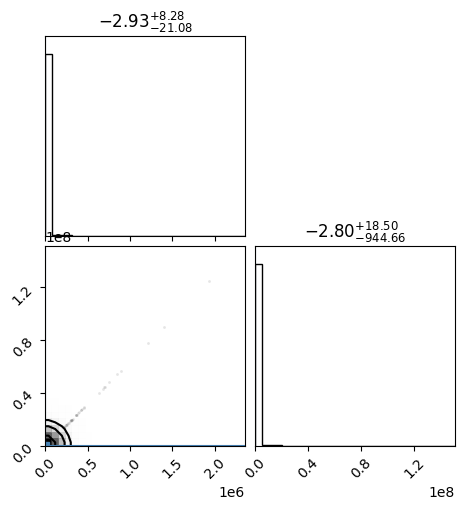

In [454]:
_ = plot_posterior(flow_cond, true_values=torch.tensor([-1., 3.]))#, lims=[[-1.5,1.5], [-0.5, 15]])

In [455]:
flow_cond.log_prob(true_parameters).detach()

tensor(-5.5219)

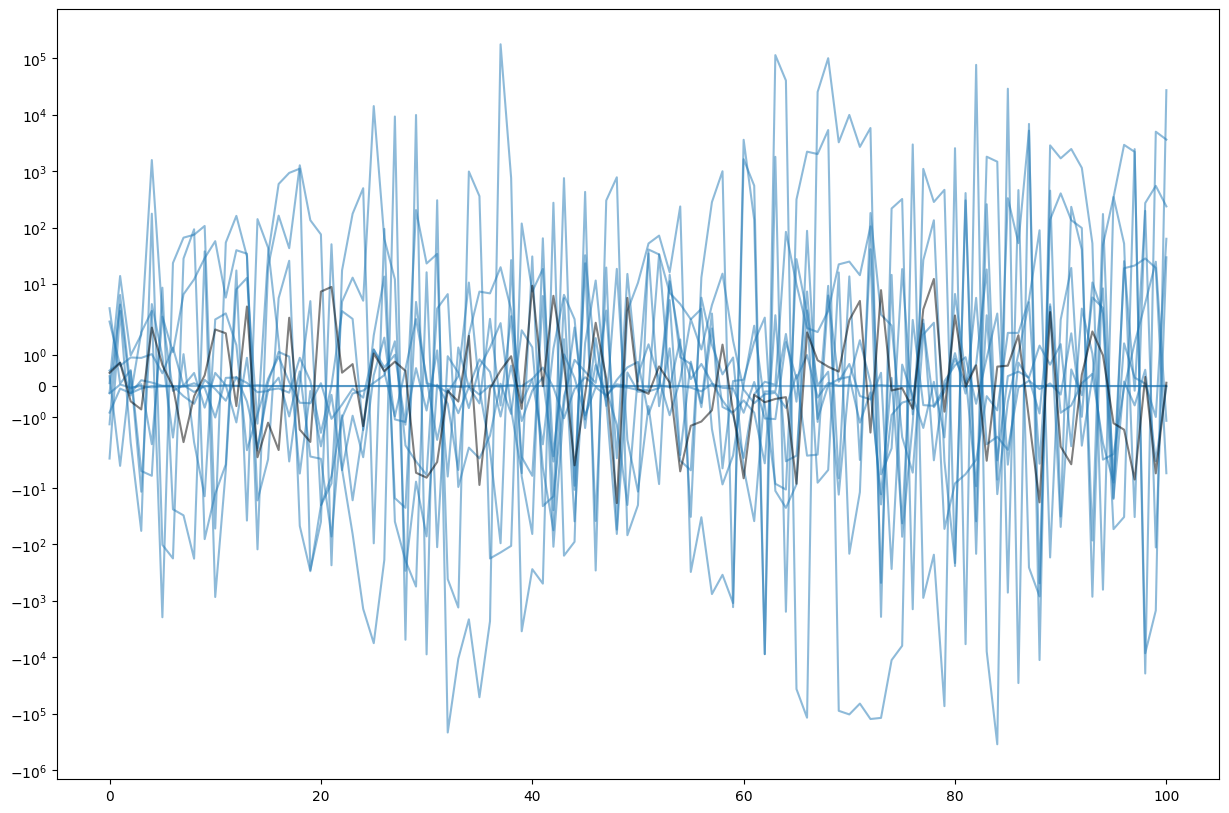

In [456]:
f, ax = plt.subplots(figsize=(15, 10))

for i in range(10):
    sample = flow(torch.ones(1)).sample()
    pred = model(sample)
    ax.plot(pred[0], color = "C0", alpha=0.5)
    
# for i in range(10):
#     sample = prior.rsample(1)
#     pred = model(sample[0])
#     ax.plot(pred[0], color = "C1", alpha=0.5)
    
# for i in range(10):
#     obs_data = model.forward(true_parameters)
#     ax.plot(obs_data[0], color = "black", alpha=0.5);


ax.plot(y, color = "black", alpha=0.5);

ax.set_yscale("symlog")
plt.show()